In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('google.csv')

In [3]:
df.head()

Date       High        Low       Open      Close      Volume  \
0  2004-08-19  51.835709  47.800831  49.813290  49.982655  44871361.0   
1  2004-08-20  54.336334  50.062355  50.316402  53.952770  22942874.0   
2  2004-08-23  56.528118  54.321388  55.168217  54.495735  18342897.0   
3  2004-08-24  55.591629  51.591621  55.412300  52.239197  15319808.0   
4  2004-08-25  53.798351  51.746044  52.284027  52.802086   9232276.0   

   Adj Close  
0  49.982655  
1  53.952770  
2  54.495735  
3  52.239197  
4  52.802086

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4317 entries, 0 to 4316
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4317 non-null   object 
 1   High       4317 non-null   float64
 2   Low        4317 non-null   float64
 3   Open       4317 non-null   float64
 4   Close      4317 non-null   float64
 5   Volume     4317 non-null   float64
 6   Adj Close  4317 non-null   float64
dtypes: float64(6), object(1)
memory usage: 236.2+ KB


In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df = df.set_index('Date')

<AxesSubplot:>

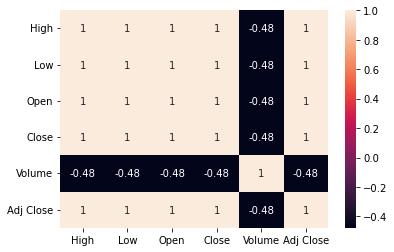

In [12]:
sns.heatmap(df.corr(), annot=True)

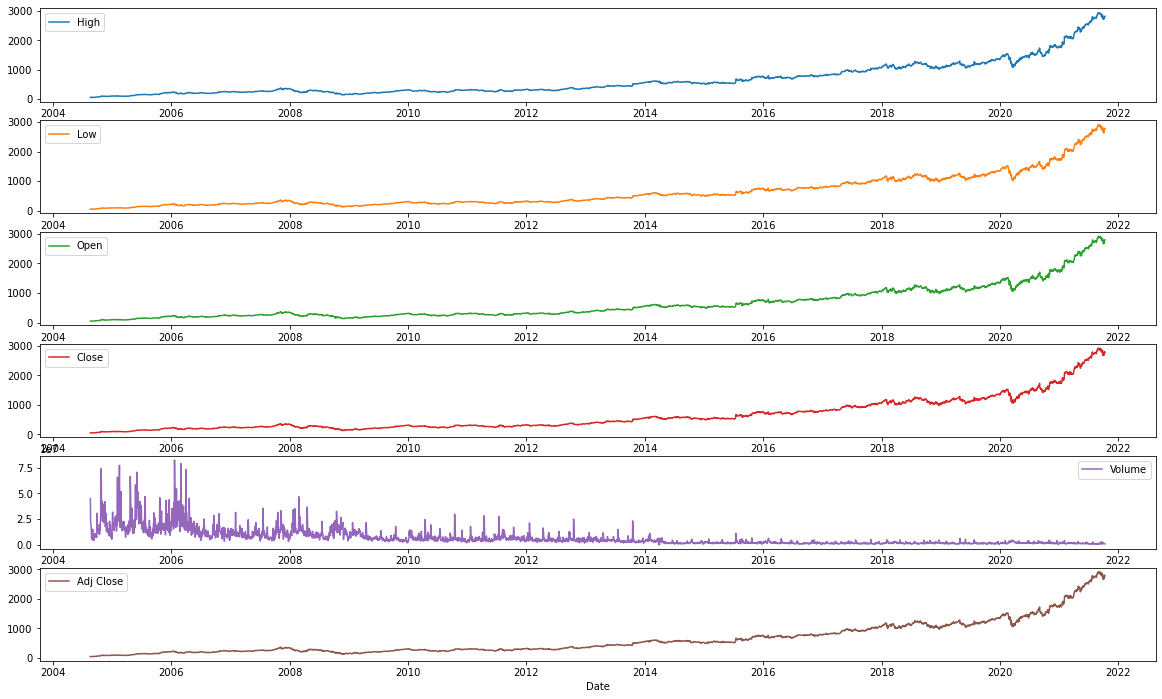

In [7]:
fig, ax = plt.subplots(figsize=(20,12))
df.plot(subplots=True, ax=ax)
plt.show()

### Adfuller test for stationarity

In [8]:
for column in df.columns:
    result = adfuller(df[column])
    
    print(f"{column} p-value: {result[1]:.2f}")

High p-value: 1.00
Low p-value: 1.00
Open p-value: 1.00
Close p-value: 1.00
Volume p-value: 0.01
Adj Close p-value: 1.00


In [9]:
# Checking for the stationarity of the data after the first differencing

for column in df.columns.drop('Volume'):
    result = adfuller(df[column].diff().dropna())
    
    print(f"{column} p-value: {result[1]:.2f}")

High p-value: 0.00
Low p-value: 0.00
Open p-value: 0.00
Close p-value: 0.00
Adj Close p-value: 0.00


From the results above, it is clear that the time series data are non-stationary and that a difference of I would make it stationary

### Check for Seasonality

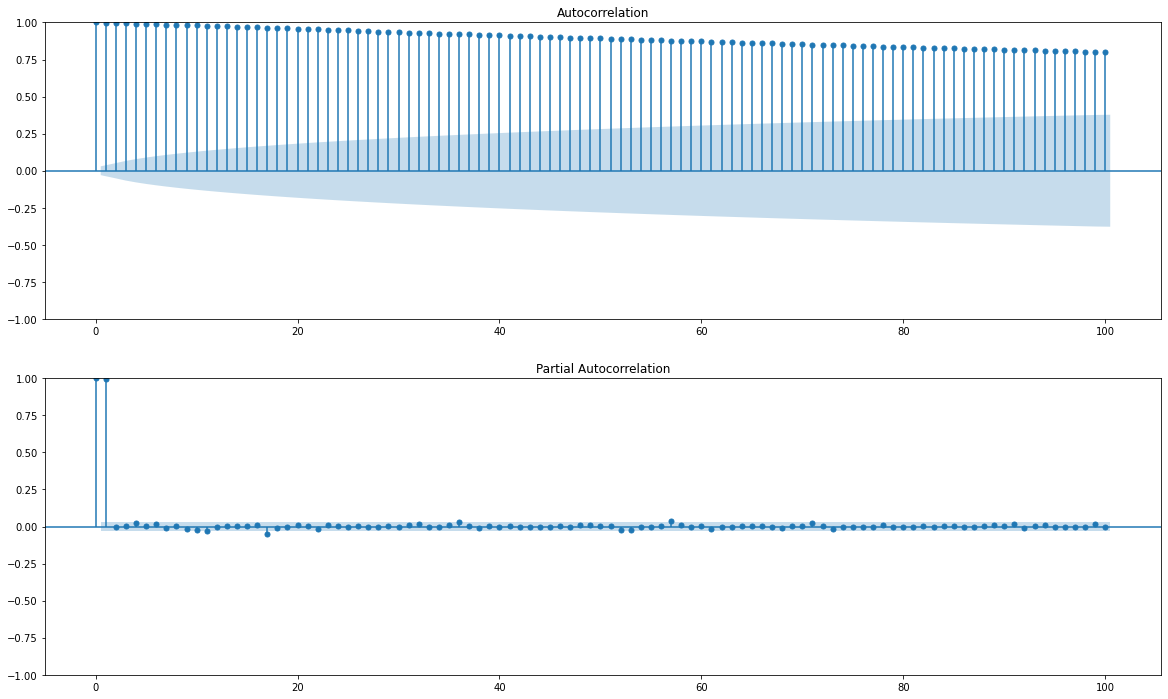

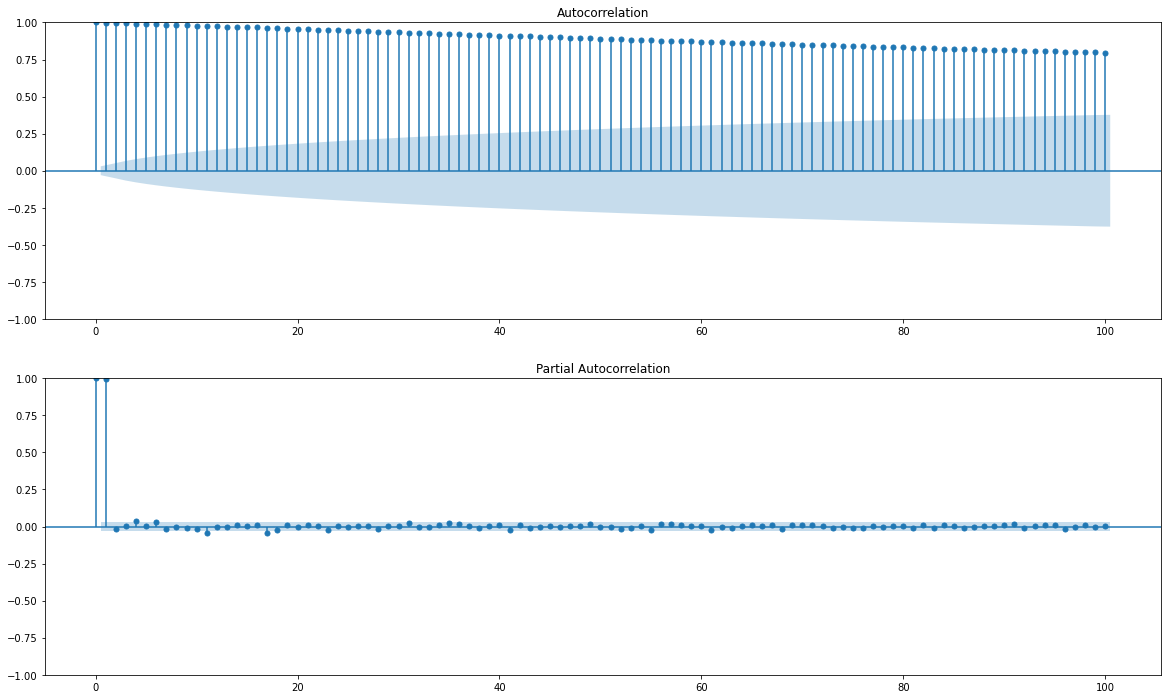

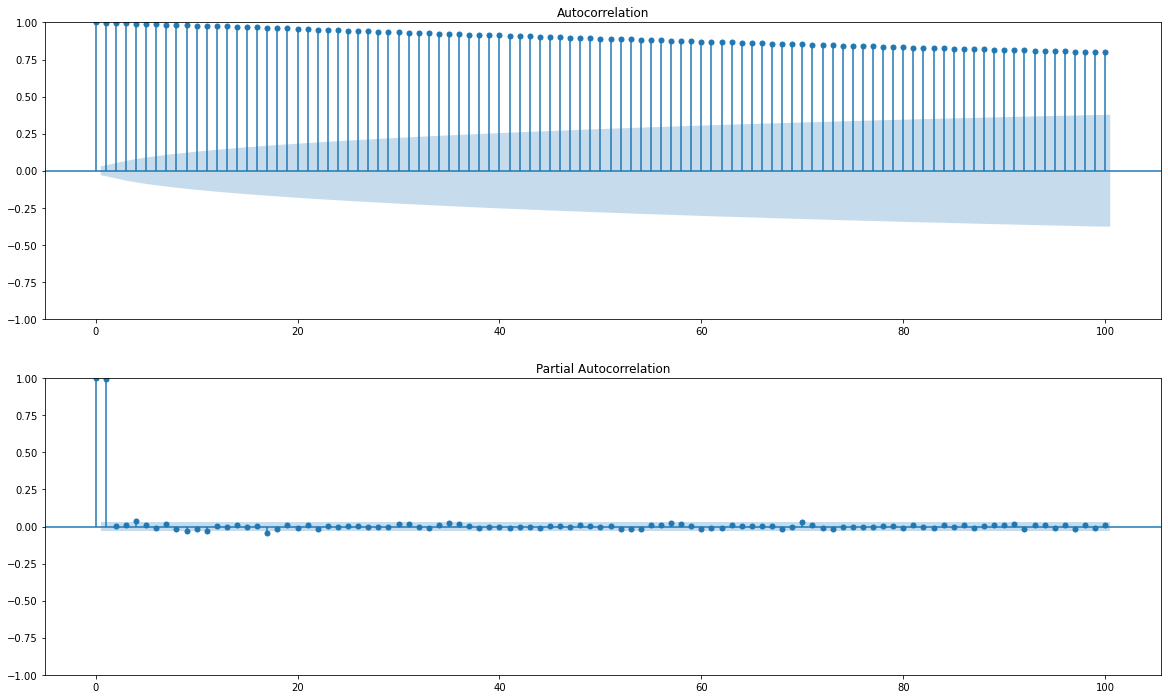

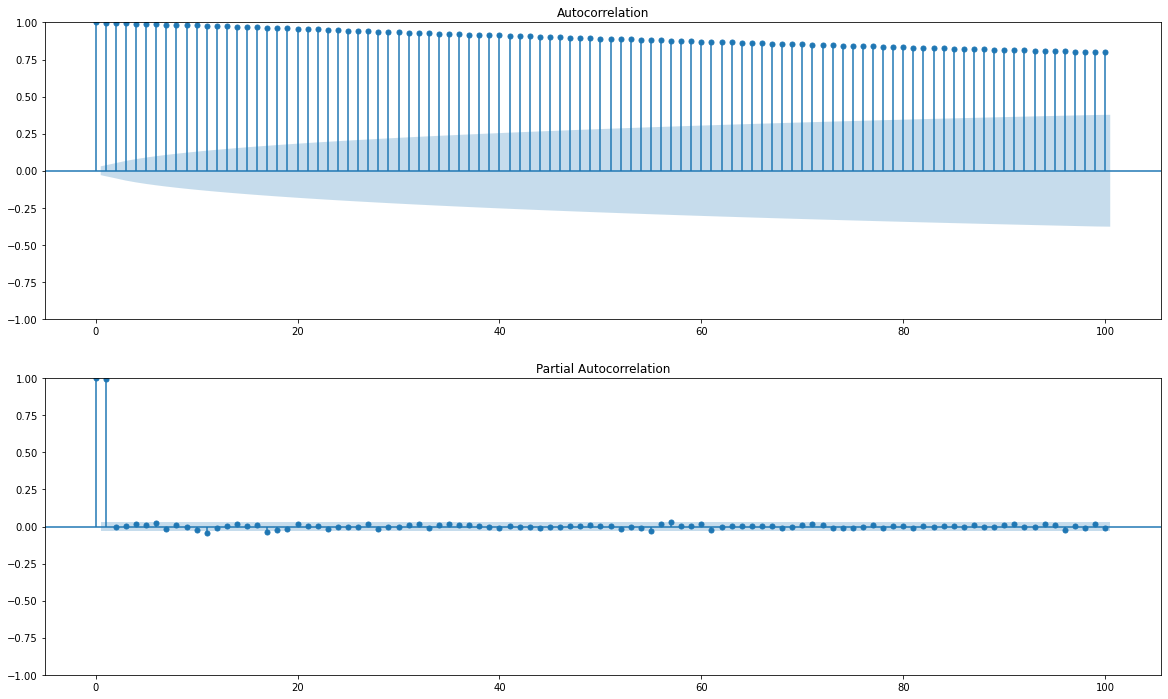

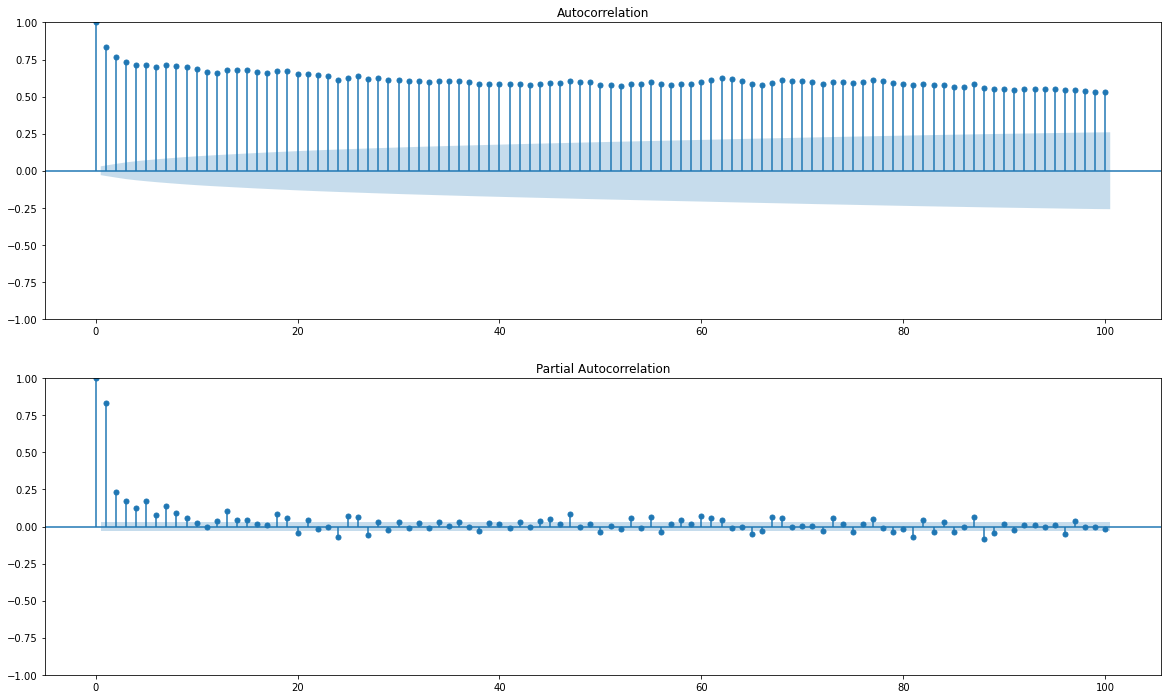

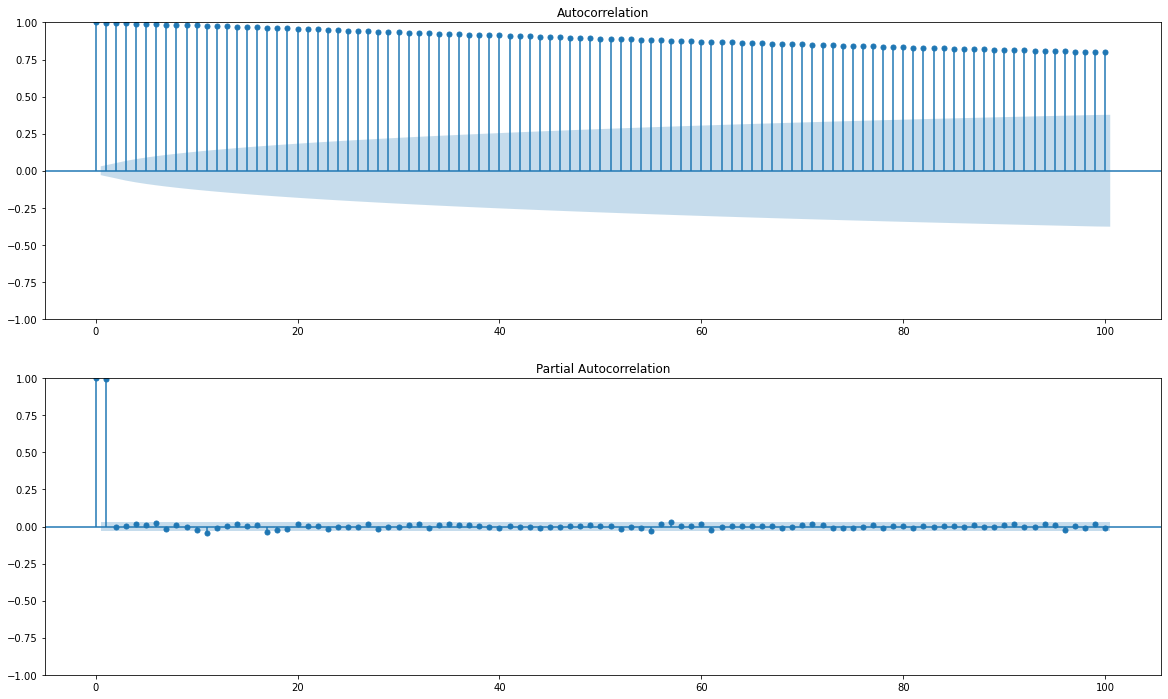

In [13]:
for col in df.columns:
    fig, ax = plt.subplots(nrows=2, figsize=(20,12))
    plot_acf(df[col], lags=100, ax=ax[0])
    plot_pacf(df[col], lags=100, ax=ax[1])

### Modelling

In [14]:
train_data, test_data = df[:int(len(df)*0.8)], df[int(len(df)*0.8):]

### Choosing Optimal Values for each time series data

In [23]:
import pmdarima as pm



for column in df.columns:
    if column != 'Volume':
        d = 1
    else:
        d = 0
        
    results = pm.auto_arima(train_data[column],
                           d=d,
                            m=1,
                           start_p=1,
                           start_q=1,
                           max_p=6,
                           seasonal=False,)
    print(f"{column} optimal values")
    print(results)
    print('*'*30)

High optimal values
 ARIMA(0,1,1)(0,0,0)[0] intercept
******************************
Low optimal values
 ARIMA(0,1,1)(0,0,0)[0] intercept
******************************
Open optimal values
 ARIMA(1,1,0)(0,0,0)[0] intercept
******************************
Close optimal values
 ARIMA(1,1,1)(0,0,0)[0] intercept
******************************
Volume optimal values
 ARIMA(4,0,4)(0,0,0)[0]          
******************************
Adj Close optimal values
 ARIMA(1,1,1)(0,0,0)[0] intercept
******************************


In [24]:
open_price_arima_model = ARIMA(train_data['Open'], order=(0,1,1)).fit()
high_price_arima_model = ARIMA(train_data['High'], order=(0,1,1)).fit()
low_price_arima_model = ARIMA(train_data['Low'], order=(1,1,0)).fit()
close_price_arima_model = ARIMA(train_data['Close'], order=(1,1,1)).fit()
volume_price_arima_model = ARIMA(train_data['Volume'], order=(4,0,4)).fit()
adj_close_price_arima_model = ARIMA(train_data['Adj Close'], order=(1,1,1)).fit()

In [25]:
train_data

High          Low         Open        Close      Volume  \
Date                                                                         
2004-08-19    51.835709    47.800831    49.813290    49.982655  44871361.0   
2004-08-20    54.336334    50.062355    50.316402    53.952770  22942874.0   
2004-08-23    56.528118    54.321388    55.168217    54.495735  18342897.0   
2004-08-24    55.591629    51.591621    55.412300    52.239197  15319808.0   
2004-08-25    53.798351    51.746044    52.284027    52.802086   9232276.0   
...                 ...          ...          ...          ...         ...   
2018-05-01  1038.469971  1008.210022  1013.659973  1037.310059   1427900.0   
2018-05-02  1040.389038  1022.869995  1028.099976  1024.380005   1603100.0   
2018-05-03  1029.675049  1006.289978  1019.000000  1023.719971   1815100.0   
2018-05-04  1048.510010  1016.900024  1016.900024  1048.209961   1938700.0   
2018-05-07  1061.680054  1047.099976  1049.229980  1054.790039   1466100.0   

              Adj Close  
Date                     
2004-08-19    49.982655  
2004-08-20    53.952770  
2004-08-23    54.495735  
2004-08-24    52.239197  
2004-08-25    52.802086  
...                 ...  
2018-05-01  1037.310059  
2018-05-02  1024.380005  
2018-05-03  1023.719971  
2018-05-04  1048.209961  
2018-05-07  1054.790039  

[3453 rows x 6 columns]

In [26]:
open_price_predictions = open_price_arima_model.get_prediction(start=-300).predicted_mean
high_price_predictions = high_price_arima_model.get_prediction(start=-300).predicted_mean
low_price_predictions = low_price_arima_model.get_prediction(start=-300).predicted_mean
close_price_predictions = close_price_arima_model.get_prediction(start=-300).predicted_mean
volume_price_predictions = volume_price_arima_model.get_prediction(start=-300).predicted_mean
adj_close_price_predictions = adj_close_price_arima_model.get_prediction(start=-300).predicted_mean

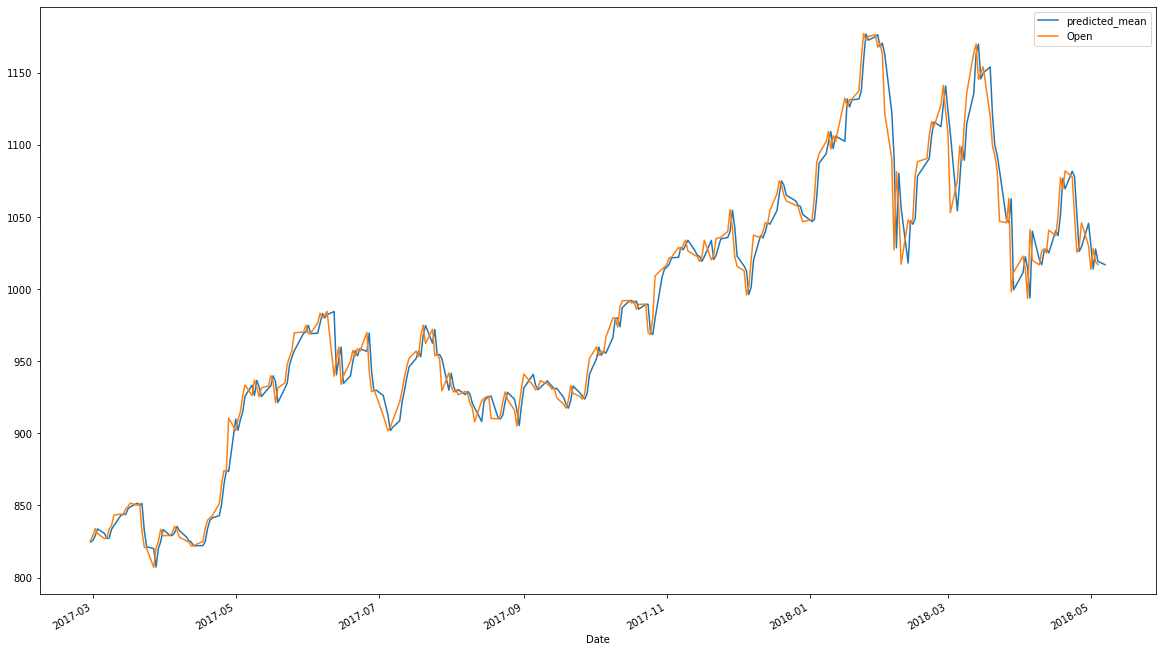

In [27]:
ax = open_price_predictions.plot(figsize=(20,12))
train_data.iloc[-300:-1]['Open'].plot(ax= ax)
plt.legend()

In [28]:
len(train_data)

3453

In [29]:
import datetime

In [30]:
test_data

High          Low         Open        Close     Volume  \
Date                                                                        
2018-05-08  1060.550049  1047.145020  1058.540039  1053.910034  1217700.0   
2018-05-09  1085.439941  1056.364990  1058.099976  1082.760010  2032800.0   
2018-05-10  1100.439941  1085.640015  1086.030029  1097.569946  1443000.0   
2018-05-11  1101.329956  1090.910034  1093.599976  1098.260010  1253700.0   
2018-05-14  1110.750000  1099.109985  1100.000000  1100.199951  1518100.0   
...                 ...          ...          ...          ...        ...   
2021-10-05  2747.239990  2680.000000  2680.000000  2723.540039  1206300.0   
2021-10-06  2757.040039  2689.729980  2692.510010  2747.080078   988200.0   
2021-10-07  2803.089111  2771.260010  2777.260010  2783.709961   912500.0   
2021-10-08  2806.340088  2788.586914  2798.120117  2801.120117   946200.0   
2021-10-11  2815.272949  2776.129883  2796.000000  2776.949951   828700.0   

              Adj Close  
Date                     
2018-05-08  1053.910034  
2018-05-09  1082.760010  
2018-05-10  1097.569946  
2018-05-11  1098.260010  
2018-05-14  1100.199951  
...                 ...  
2021-10-05  2723.540039  
2021-10-06  2747.080078  
2021-10-07  2783.709961  
2021-10-08  2801.120117  
2021-10-11  2776.949951  

[864 rows x 6 columns]

In [31]:
open_price_forecasts = open_price_arima_model.forecast(len(test_data), alpha=0.05, dynamic=True)
high_price_forecasts = high_price_arima_model.forecast(len(test_data), alpha=0.05, dynamic=True)
low_price_forecasts = low_price_arima_model.forecast(len(test_data), alpha=0.05, dynamic=True)
close_price_forecasts = close_price_arima_model.forecast(len(test_data), alpha=0.05, dynamic=True)
volume_price_forecasts = volume_price_arima_model.forecast(len(test_data), alpha=0.05, dynamic=True)
adj_close_price_forecasts = adj_close_price_arima_model.forecast(len(test_data), alpha=0.05, dynamic=True)

In [32]:
open_price_forecasts.index = test_data.index
high_price_forecasts.index = test_data.index 
low_price_forecasts.index = test_data.index 
close_price_forecasts.index = test_data.index
volume_price_forecasts.index = test_data.index
adj_close_price_forecasts.index = test_data.index

In [33]:
open_price_forecasts

Date
2018-05-08    1048.492858
2018-05-09    1048.492858
2018-05-10    1048.492858
2018-05-11    1048.492858
2018-05-14    1048.492858
                 ...     
2021-10-05    1048.492858
2021-10-06    1048.492858
2021-10-07    1048.492858
2021-10-08    1048.492858
2021-10-11    1048.492858
Name: predicted_mean, Length: 864, dtype: float64

In [34]:
predictions = pd.DataFrame(data={
                'Open': open_price_forecasts,
                'High': high_price_forecasts,
                'Low': low_price_forecasts,
                'Close': close_price_forecasts,
                'Volume': volume_price_forecasts,
                'Adj Close': adj_close_price_forecasts
                },
                index=test_data.index)

In [35]:
predictions

Open         High          Low        Close        Volume  \
Date                                                                           
2018-05-08  1048.492858  1063.032799  1051.264945  1054.731853  1.839373e+06   
2018-05-09  1048.492858  1063.032799  1051.839348  1054.767192  1.882866e+06   
2018-05-10  1048.492858  1063.032799  1051.918566  1054.745729  1.898724e+06   
2018-05-11  1048.492858  1063.032799  1051.929491  1054.758764  2.045389e+06   
2018-05-14  1048.492858  1063.032799  1051.930998  1054.750847  1.933677e+06   
...                 ...          ...          ...          ...           ...   
2021-10-05  1048.492858  1063.032799  1051.931239  1054.753839  4.763710e+06   
2021-10-06  1048.492858  1063.032799  1051.931239  1054.753839  4.765997e+06   
2021-10-07  1048.492858  1063.032799  1051.931239  1054.753839  4.768284e+06   
2021-10-08  1048.492858  1063.032799  1051.931239  1054.753839  4.770568e+06   
2021-10-11  1048.492858  1063.032799  1051.931239  1054.753839  4.772851e+06   

              Adj Close  
Date                     
2018-05-08  1054.731853  
2018-05-09  1054.767192  
2018-05-10  1054.745729  
2018-05-11  1054.758764  
2018-05-14  1054.750847  
...                 ...  
2021-10-05  1054.753839  
2021-10-06  1054.753839  
2021-10-07  1054.753839  
2021-10-08  1054.753839  
2021-10-11  1054.753839  

[864 rows x 6 columns]

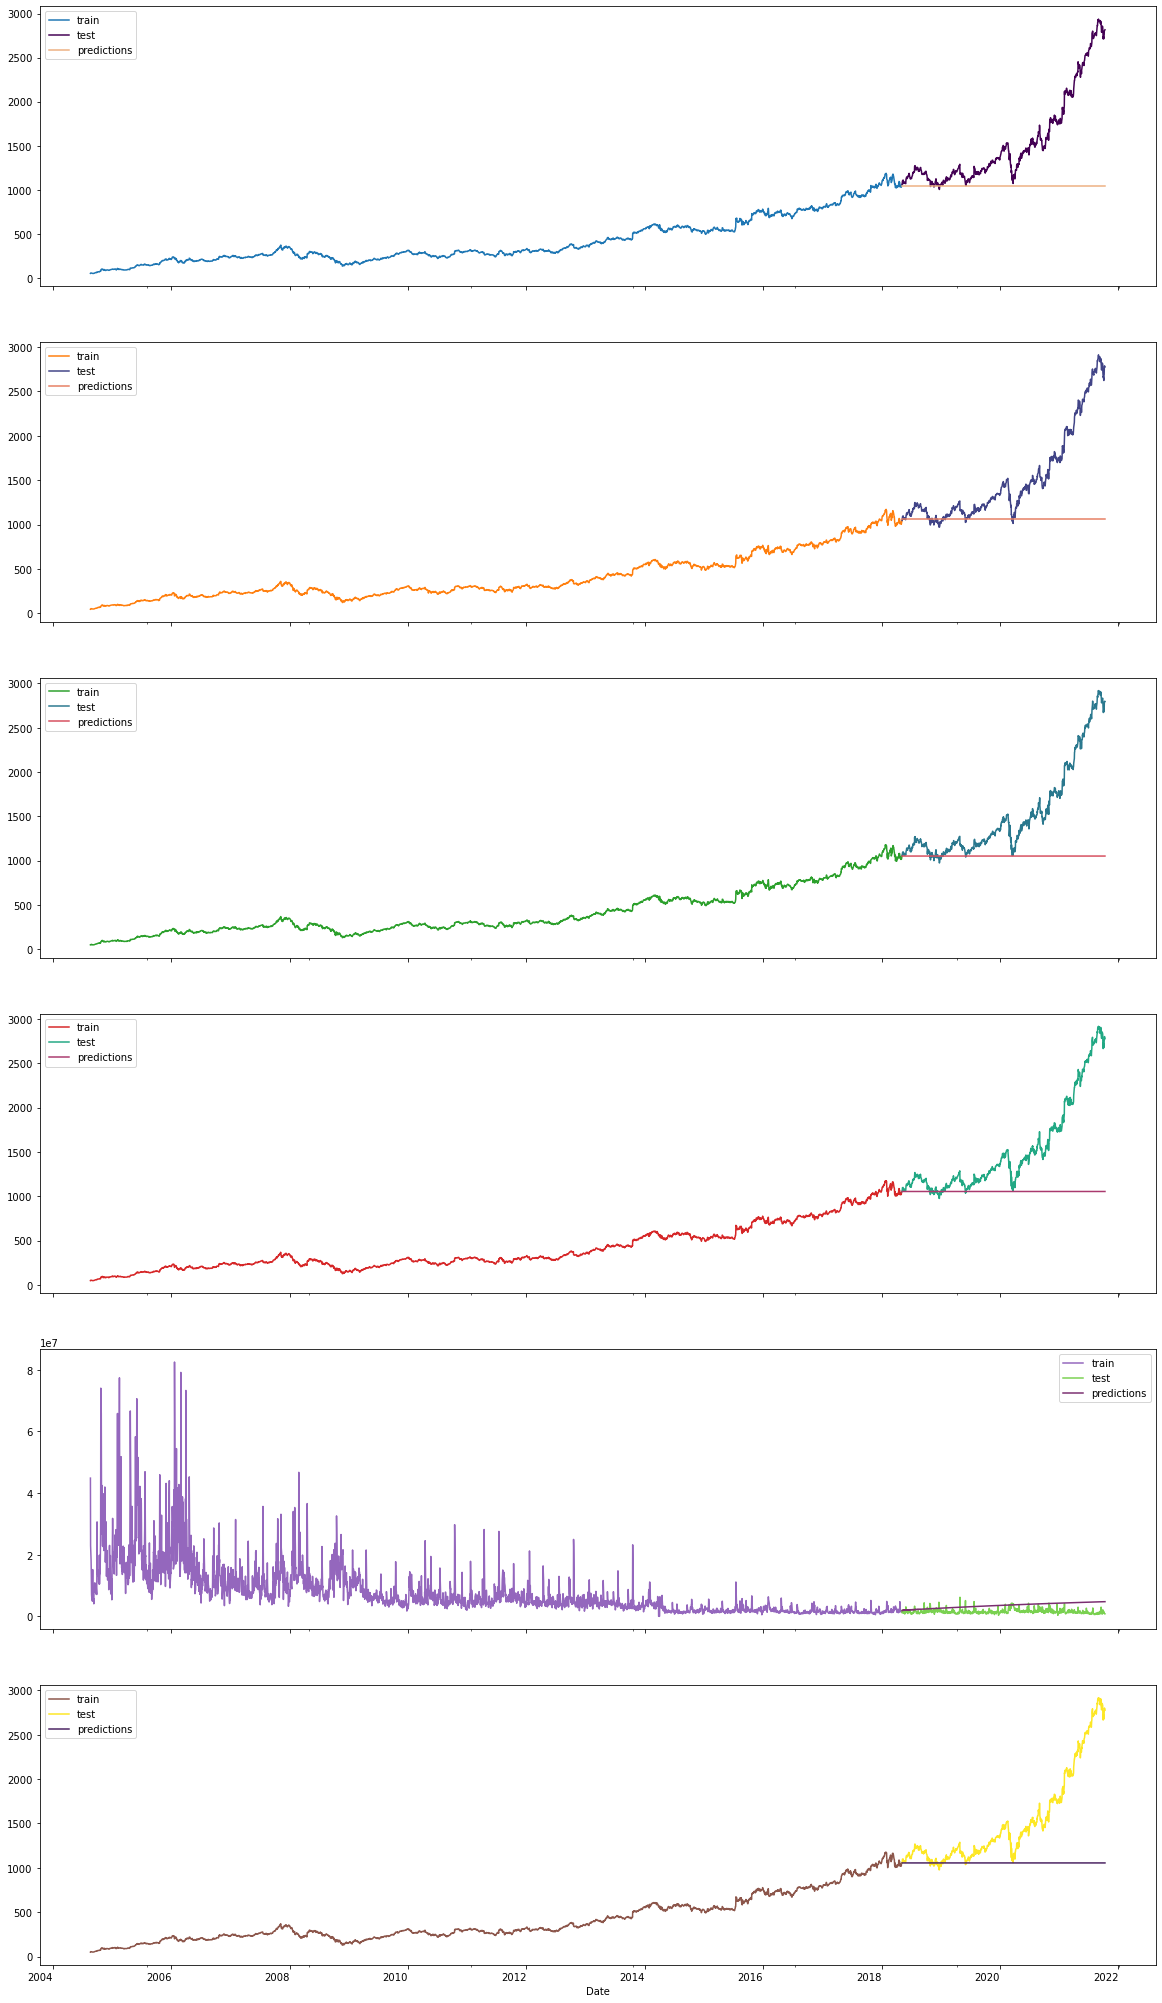

In [36]:
ax = train_data.plot(subplots=True, figsize=(20,40))
test_data.plot(subplots=True, ax=ax, cmap='viridis')
predictions.plot(subplots=True, ax=ax, cmap='flare')
for _ in ax:
    _.legend(['train', 'test', 'predictions'])
plt.show()

In [44]:
def evaluate_model(column):
    return np.sqrt(mean_squared_error(test_data[column], predictions[column]))

In [45]:
evaluate_model('Open')

711.0751278693108

In [46]:
evaluate_model('High')

714.4917451542352

In [48]:
evaluate_model('Low')

697.2694575832259

In [49]:
evaluate_model('Close')

708.4844036121883

In [51]:
evaluate_model('Volume')

2241395.710963807

In [50]:
evaluate_model('Adj Close')

708.4844036121883